<a href="https://colab.research.google.com/github/s1250103/Public_mori-lab/blob/eras/eras/tune/programs/analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
#@title 前処理
# import
# file dealing
import os
from os import path
import shutil
from google.colab import drive
import datetime
# data dealing
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
# process deasing
import gc
from time import sleep
# machine learning (back)
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, initializers, callbacks
# machine learning
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical
# others
import json
from collections import OrderedDict
import pprint


# gdrive 接続
if not path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Already confirm to build gdrive")

# colab テンポラリディレクトリの作成
desk = '/content/desk'
if not os.path.exists(desk):
  os.mkdir(desk)
os.chdir(desk)
print("Created at /content/desk")


Already confirm to build gdrive
Created at /content/desk


#データをインポート

In [306]:
pathHistories = "/content/drive/MyDrive/colab/histories"
os.chdir(pathHistories)

history_directories = os.listdir(pathHistories)
history_directories.remove('.ipynb_checkpoints')
history_directories.reverse()

for each in history_directories:
  print(each)

0113-1929
0113-1820
0113-1734
0113-1649
0113-1510
0113-1408
0112-1834
0112-1631
0112-1552


In [307]:
import re

pickups = [0] 

examines = []

csv_pattern = re.compile(".*\.csv")
cce_pattern = re.compile(".*cce.*")
mse_pattern = re.compile(".*mse.*")
json_pattern = re.compile(".*\.json")

for pick_one in pickups:
  print("the directory : ", history_directories[pick_one])
  inFiles = os.listdir(history_directories[pick_one])
  print("in:", inFiles)

  # desk に持ってくる機能
  # dst = os.path.join(desk, history_directories[pick_one])
  # shutil.copytree(history_directories[pick_one], dst, ignore=None, copy_function=shutil.copy2)
  csvs = []
  for file in inFiles:
    file_path = os.path.join(pathHistories, history_directories[pick_one])
    file_path = os.path.join(file_path, file)
    # when csv files    
    if csv_pattern.match(file):
      # それを変数として取り込む
      if cce_pattern.match(file):
        print("read cce")
        page = {
            "loss" : "cce",
            "data" : pd.read_csv(file_path, engine='python') 
        }
      elif mse_pattern.match(file):
        print("read mse")
        page = {
            "loss" : "mse",
            "data" : pd.read_csv(file_path, engine='python')
        }
      csvs.append(page)
    elif json_pattern.match(file):
      with open(file_path) as f:
        json_load = json.load(f) 
      print("read json file")


  #/for file
  examines.append(csvs)
  print("-----------------------------------------------------------------------------------------------------")
#/for

the directory :  0113-1929
in: ['0113-1929cce.csv', 'situation.json', '0113-1929mse.csv']
read cce
read json file
read mse
-----------------------------------------------------------------------------------------------------


In [308]:
#@title プロット機能
def plot_one_learning(one_learning, useLoss, experiment_name="No name"):
  HEIGHT = 1
  WIDTH = 4

  rate = 6.0
  fig = plt.figure(figsize=(WIDTH*rate*2, HEIGHT*rate))

  LOSS = fig.add_subplot(HEIGHT, WIDTH, 1) # loss, val_loss
  ACC = fig.add_subplot(HEIGHT, WIDTH, 2) # acc, val_acc
  LOSS_head = fig.add_subplot(HEIGHT, WIDTH, 3) # head of loss, val_loss
  MEMO =  fig.add_subplot(HEIGHT, WIDTH, 4) # memo
  # plt.subplots_adjust(left=None, bottom=None, right=2.0, top=1.5, wspace=0.5, hspace=0.5)
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
  # 1,1 loss
  loss = one_learning["loss"]
  val_loss = one_learning["val_loss"]

  loss_props = {
        'title' : 'Loss values plot',
        'xlabel' : 'epoch',
        'ylabel' : 'value'
    }
  LOSS.set(**loss_props)
  LOSS.plot(loss, label='loss', color='blue')
  LOSS.plot(val_loss, label='val_loss', color='orange')
  LOSS.legend(loc='best')

  # 1,2 acc
  acc = one_learning['acc']
  val_acc = one_learning['val_acc']
  acc_props = {
        'title' : 'Accuracy values plot',
        'xlabel' : 'epoch',
        'ylabel' : 'value'
    }

  crisis_data = [
                 (one_learning["acc"][len(one_learning["acc"]) - 1], 'last acc'),
                 (format(one_learning["val_acc"][len(one_learning["val_acc"]) - 1], '.6f'), 'last val_acc')
  ]

  ACC.set(**acc_props)
  ACC.text(0.8, 0.85, crisis_data_write(crisis_data), ha='right', va='top', transform=ACC.transAxes, size=10)
   

  ACC.plot(acc, label='acc', color='blue')
  ACC.plot(val_acc, label='val_acc', color='orange')
  ACC.legend(loc='best')

# 1,3 loss head
  end_point = 50
  loss_head = one_learning["loss"][:end_point]
  val_loss_head = one_learning["val_loss"][:end_point]
  loss_head_props = {
        # 'title' : 'Loss values plot [0 - 100]',
        'title' : 'Loss values plot [0 - ' + str(end_point) + ']',
        'xlabel' : 'epoch',
        'ylabel' : 'value'
    }

  LOSS_head.set(**loss_head_props)
  LOSS_head.plot(loss_head, label='loss_head', color='blue')
  LOSS_head.plot(val_loss_head, label='val_loss_head', color='orange')
  LOSS_head.legend(loc='best')
  
# 1,4 memo
  tmp = {
      'title' : 'memo',
      'xticks' : ([]),
      'yticks' : ([]),
  }

  MEMO.set(**tmp)
  MEMO.text(0.11, 0.3, memo_write(useLoss, experiment_name), size=10)

  #save
  path_image = os.path.join(desk, useLoss)
  fig.savefig(path_image, bbox_inches='tight')

def memo_write(useLoss, experiment_name):
  sentence = ""
  sentence += useLoss + " is used as a loss function\n\n"
  sentence += pprint.pformat(json_load) + "\n\n"
  sentence += "The Directory name : " + experiment_name
  return sentence

def crisis_data_write(crisis_data):
  sentence = ""
  sentence += str(crisis_data[0][1]) + " = " + str(crisis_data[0][0]) + "\n"
  sentence += str(crisis_data[1][1]) + " = " + str(crisis_data[1][0]) + "\n"
  return sentence



In [311]:
history_directories[0]

'0113-1929'

The directory :  0113-1929
cce
mse


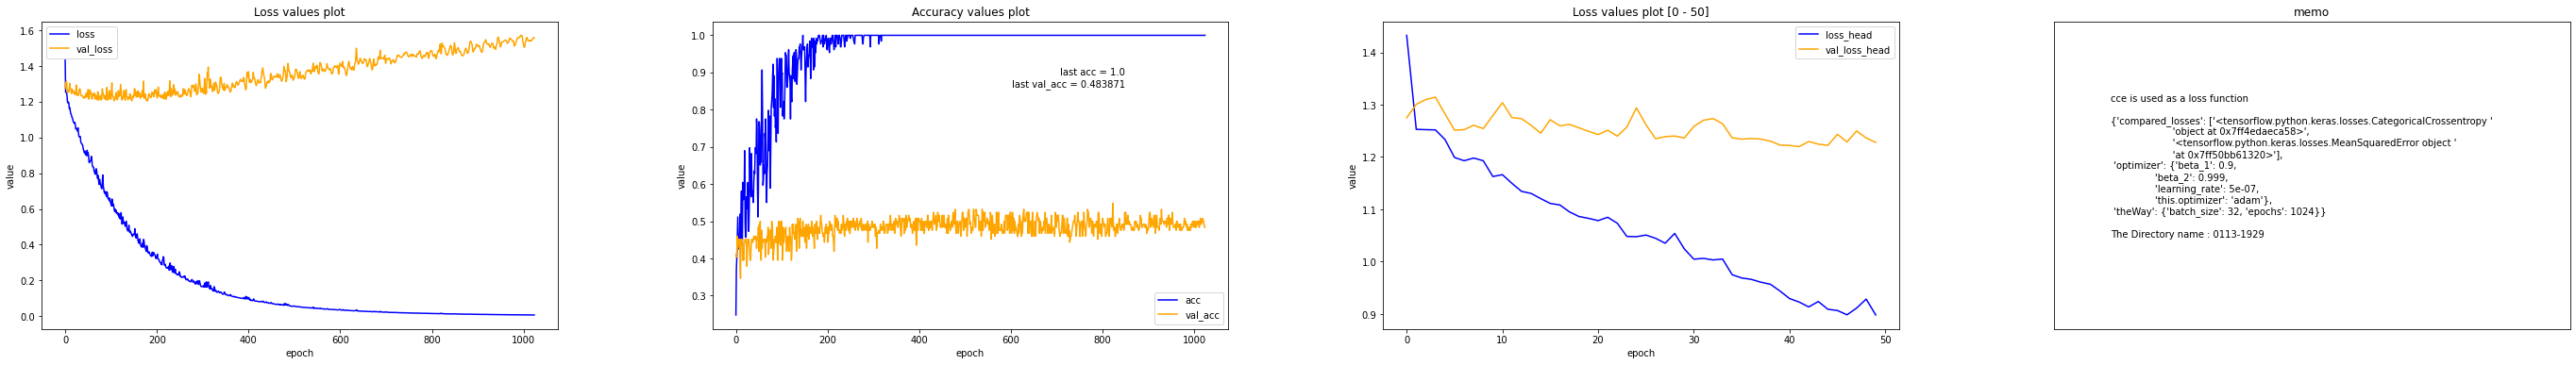

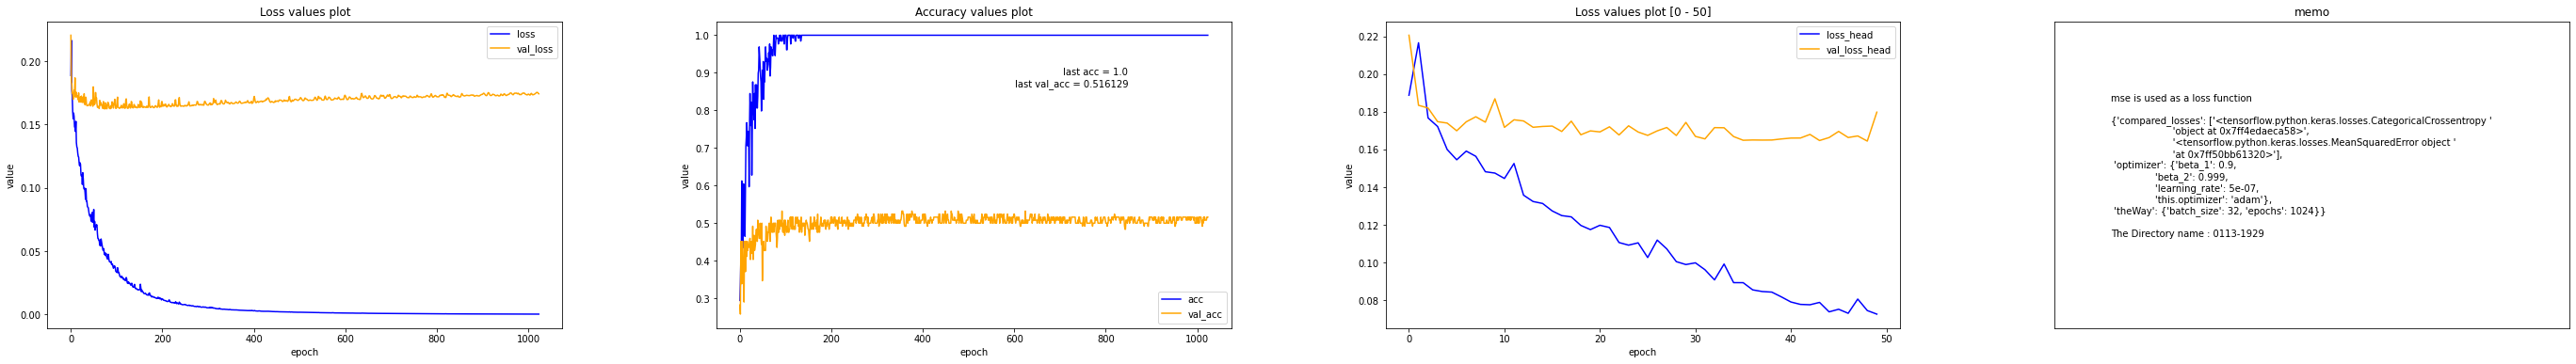

In [313]:
tmp = 0 # 見たい数-1

print("The directory : ", history_directories[tmp])
for n, one in enumerate(examines[tmp]):
  print(one["loss"])
  plot_one_learning(one["data"], one["loss"], history_directories[pickups[tmp]])


In [ ]:
#@title プロット用モジュール
def plot(history, elementsDict, name='tmp'):
  HEIGHT = 2
  WIDTH = 2

  # 下地の用意
  fig = plt.figure()
  LOSS = fig.add_subplot(HEIGHT, WIDTH, 1)
  ACC = fig.add_subplot(HEIGHT, WIDTH, 2)
  LOSSDIF = fig.add_subplot(HEIGHT, WIDTH, 3)
  LEARNING_OUTLINE = fig.add_subplot(HEIGHT, WIDTH, 4)


  plt.subplots_adjust(left=None, bottom=None, right=1.5, top=1.5, wspace=0.5, hspace=0.5)

  # 1,1 loss
  loss = DataFrame(history.history['loss'])
  val_loss = DataFrame(history.history['val_loss'])
  loss_props = {
        'title' : 'Loss values plot',
        'xlabel' : 'epoch',
        'ylabel' : 'value'
    }
  LOSS.set(**loss_props)
  LOSS.plot(loss, label='loss', color='blue')
  LOSS.plot(val_loss, label='val_loss', color='orange')
  LOSS.legend(loc='best')

  # 1,2 acc
  acc = DataFrame(history.history['acc'])
  val_acc = DataFrame(history.history['val_acc'])
  acc_props = {
        'title' : 'Accuracy values plot',
        'xlabel' : 'epoch',
        'ylabel' : 'value'
    }
  ACC.set(**acc_props)
  ACC.plot(acc, label='acc', color='blue')
  ACC.plot(val_acc, label='val_acc', color='orange')
  ACC.legend(loc='best')

  #2,1 loss.diff
  loss_diff_props = {
      'title' : 'Derivative values plot',
      # 'xlabel' : 'epoch',
      'ylabel' : 'value'
  }
  LOSSDIF.set(**loss_diff_props)
  LOSSDIF.plot(loss.diff(), label='loss_diff', color='blue')
  LOSSDIF.plot(val_loss.diff(), label='val_loss_diff', color='orange')
  LOSSDIF.legend(loc='best')

  # 2,2 learning outline
  tmp = {
      'title' : 'learning outline',
      'xticks' : ([]),
      'yticks' : ([]),
  }

  LEARNING_OUTLINE.set(**tmp)
  LEARNING_OUTLINE.text(0.1, 0.5, modelOutline(elementsDict), size=10)

  #save
  path_image = os.path.join(desk, name)
  fig.savefig(path_image, bbox_inches='tight')

def modelOutline(elementsDict):
  sentence = ""

  for each in elementsDict.keys():
    if isinstance(elementsDict[each], int) or isinstance(elementsDict[each], float):
      sentence = sentence + each + " : " + str(elementsDict[each]) + "\n"
      # print(str(elementsDict[each]))
    else:
      sentence = sentence + each + " : " + get_var_name(elementsDict[each]) + "\n"
      # print(get_var_name(elementsDict[each]))
  return sentence

def get_var_name(var):
    for k,v in globals().items():
        if id(v) == id(var):
            name=k
    return name

